# Multicompartment Modeling of Influenza A Replication Along the Murine Respiratory Tract

*Authors: Rodolfo Blanco-Rodriguez, L. America Chi, Esteban Hernandez-Vargas*

## 0. Importing Essential Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.optimize import differential_evolution

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
import seaborn as sns

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True

viridis_pal = sns.color_palette('viridis', n_colors=8)
rocket_pal = sns.color_palette('rocket', n_colors=3)

### 0.1. Helpers

In [2]:
def safeLog10(x, eps=1e-8):
    return np.log10(x + eps)

In [3]:
def AICc(LRSS, k, n):
    LRSS_ln = LRSS * (np.log(10))**2
    return n*np.log(LRSS_ln / n) + 2 * k + (2 * k * (k + 1)) / (n - k - 1)

## 1. Load Data

In [4]:
# Viral Data in log scale
dfData_V = pd.read_csv('data/viral_load.csv')
dfData_V

,Day,nose,trachea,lung,stdN,stdT,stdL
0,1,4.12033,1.44097,1.00111,0.85892,0.47830,0.02002
1,2,5.07884,3.60242,2.36263,0.63485,0.58729,0.94104
2,3,3.94606,4.69828,3.21023,0.35477,0.69022,1.58844
3,4,4.51867,4.64379,4.07119,0.15560,0.90212,1.40823
4,5,4.48133,4.14127,2.14238,0.58506,1.15641,1.48165
5,6,3.67220,2.61554,4.41157,0.22407,0.36327,0.26696
6,7,3.23029,0.99899,1.14127,0.27386,0.02422,0.32035
7,8,1.16390,0.99899,0.99444,0.23029,0.01816,0.02002


## 2. Model Definition

The system is divided into three compartments representing different anatomical regions of the mouse respiratory system: the nose ($i=1$), trachea ($i=2$), and lungs ($i=3$).

\begin{align}
\dot{U}_i &= -\beta_i U_i V_i - \xi_i U_i F_i, \\
\dot{I}_i &= \beta_i U_i V_i - \delta_i I_i - k_i T I_i, \\
\dot{F}_i &= \alpha_i I_i - \phi_i F_i, \\
\dot{V}_i &= p_i I_i - c_i V_i + \sum_{j=1}^3 \Gamma_{ij} V_j \\
\dot{T}   &= s_T + r T\sum_{i=1}^{3} I_i - \mu T
\end{align}

where:
$$ \Gamma = \begin{pmatrix}
    -\gamma_{12} & \gamma_{21} & 0 \\
    \gamma_{12} & -\gamma_{21} - \gamma_{23} & \gamma_{32} \\
    0 & \gamma_{23} & -\gamma_{32}
    \end{pmatrix} $$

In [5]:
def fullModel(y, t, params, M):
    # Unpack state variables
    U1, U2, U3, I1, I2, I3, F1, F2, F3, V1, V2, V3, T = y

    # arrays of shape (3,)
    beta = 10**params['beta']
    # delta = 10**params['delta']
    delta = np.array([1.8, 1.8, 1.8])
    # p = 10**params['p']
    p = np.array([1.0, 1.0, 1.0])
    # c = 10**params['c']
    c = np.array([4.2, 4.2, 4.2])

    xi = 10**params['xi'] # or rho for M2
    k = 10**params['k']
    alpha = 10**params['alpha']
    # phi = 10**params['phi']
    # phi = np.array([4.0, 4.0, 4.0])
    phi = np.array([2.0, 2.0, 2.0])

    # For the Gamma matrix:
    gamma12 = 10**params['gamma12']
    gamma21 = 10**params['gamma21']
    gamma23 = 10**params['gamma23']
    gamma32 = 10**params['gamma32']

    # Immune parameters
    r = 10**params['r']
    # mu = 10**params['mu']
    mu = 0.011
    s_T = mu*params['T_0']
    
    # Construct Gamma matrix
    Gamma = np.array([
        [-gamma12,  gamma21,       0],
        [ gamma12, -gamma21-gamma23, gamma32],
        [      0,  gamma23,     -gamma32]
    ])
    
    U = np.array([U1, U2, U3])
    I = np.array([I1, I2, I3])
    F = np.array([F1, F2, F3])
    V = np.array([V1, V2, V3])
    
    # Compute derivatives
    if M == 1:
        dU_dt = -beta * U * V
        dI_dt = beta * U * V - delta * I
        dF_dt = np.array([0.0, 0.0, 0.0])
        dV_dt = p * I - c * V + Gamma.dot(V)
        dT_dt = 0.0

    if M == 2:
        dU_dt = -beta * U * V - xi * U * I
        dI_dt = beta * U * V - delta * I
        dF_dt = np.array([0.0, 0.0, 0.0])
        dV_dt = p * I - c * V + Gamma.dot(V)
        dT_dt = 0.0

    if M == 3:
        dU_dt = -beta * U * V - xi * U * F
        dI_dt = beta * U * V - delta * I - k * T * I
        dF_dt = alpha * I - phi * F
        dV_dt = p * I - c * V + Gamma.dot(V)
        dT_dt = 0.0

    if M == 4:
        dU_dt = -beta * U * V
        dI_dt = beta * U * V - delta * I - k * T * I
        dF_dt = np.array([0.0, 0.0, 0.0])
        dV_dt = p * I - c * V + Gamma.dot(V)
        dT_dt = s_T + r * T * np.sum(I) - mu * T
        # dT_dt = s_T + r * T * np.sum(V) - mu * T
    
    # Concatenate derivatives into a single array
    dydt = np.concatenate([dU_dt, dI_dt, dF_dt, dV_dt, [dT_dt]])
    return dydt

The Respiratory Tract consist in Nasal Cavity, Trachea, and Lungs (Alveoli and Bronchioles). In a mouse the quantity of susceptble cells
per compartament is estimated to:

| Compartment | Area | Cells |
|--- | ---| ---|
|Nose | $3 \times 10^8 \  \mu$m$^2$ (Asahi et al. 2002) | $3 \times 10^6$ |
|Trachea | $2 \times 10^5 \ \mu$m$^2$ (Kishimoto et al. 2021) | $2 \times 10^3$ |
|Lungs | $80 \times 10^8 \ \mu$m$^2$ (Knust et al. 2009) | $4 \times 10^6$ |

considering a surface area for one ciliated epithelial cell of 100 $\mu$m$^2$ for Nose and Trachea (Lawson et al. 2002), and a diameter of one alvealar type I cell of 50 $\mu$m, ~ 2000 $\mu$m$^2$ (Cheng et al. 2004) for Lungs.

## 3. Cost Function
To calibrate the models against the viral load data (nose, trachea, and lungs), we minimized the Logarithmic Residual Sum of Squares (LRSS), defined as
$$ \text{LRSS} = \sum_{i=1}^{3} \sum_{k=1}^{n_i} \left( \log V_{ik} - \log \hat{V}_{ik} \right)^2 $$

In [6]:
def LRSS(params, dfData_V, model, initialCond, M=1):

    # Parameter dictionary
    pars = {
        'V1_0': 10**params[0],
        'T_0': 10**params[1],
        'beta': np.array([params[2], params[3], params[4]]),
        'delta': np.array([params[5], params[6], params[7]]),
        'p': np.array([params[8], params[9], params[10]]),
        'c': np.array([params[11], params[12], params[13]]),
        'xi': np.array([params[14], params[15], params[16]]),
        'k': np.array([params[17], params[18], params[19]]),
        'alpha': np.array([params[20], params[21], params[22]]),
        'phi': np.array([params[23], params[24], params[25]]),
        'gamma12': params[26],
        'gamma21': params[27],
        'gamma23': params[28],
        'gamma32': params[29],
        'r': params[30],
        'mu': params[31],
    }

    # Initial condition
    y0 = initialCond.copy()
    y0[9] = pars['V1_0']
    y0[-1] = pars['T_0']

    # Original times (can contain duplicates)
    t_data = dfData_V.iloc[:, 0].values

    # Unique times for integration
    t_unique = np.unique(t_data)
    if not (t_unique == 0).any():
        t_unique = np.insert(t_unique, 0, 0.0)

    ####################################
    # This part checks to see if any constraints have been violated.
    tsim = np.linspace(0, np.max(t_unique), 1001)
    sol_sim = odeint(model, y0, tsim, args=(pars, M))

    penalty = 0.0
    
    #### Lung viral load
    Vsim = sol_sim[:, 11]
    tmin, tmax = 2, 6
    vmin, vmax = 10**3, 10**6
    mask = (tsim >= tmin) & (tsim <= tmax)
    if not np.any((Vsim[mask] >= vmin) & (Vsim[mask] <= vmax)):
        penalty += 1000

    tmin, tmax = 7, 9
    vmax = 10
    mask = (tsim >= tmin) & (tsim <= tmax)
    if not np.any(Vsim[mask] <= vmax):
        penalty += 1000

    # tmin, tmax = 8
    # vmax = 10
    # mask = tsim >= tmin
    # if np.any(Vsim[mask] > vmax):
    #     penalty += 1000

    #### Trachea viral load
    Vsim = sol_sim[:, 10]
    tmin, tmax = 7, 9
    vmax = 10
    mask = (tsim >= tmin) & (tsim <= tmax)
    if not np.any(Vsim[mask] <= vmax):
        penalty += 1000

    #### Lung IFN level
    if M == 3:
        Fsim = sol_sim[:, 8]
        tmin, tmax = 3, 7
        fmin, fmax = 4, 7

        idx_peak = np.argmax(Fsim)
        t_peak = tsim[idx_peak]
        f_peak = Fsim[idx_peak]

        time_flag = tmin <= t_peak <= tmax
        f_flag = fmin <= f_peak <= fmax

        if not (time_flag and f_flag):
            penalty += 1000

        #### Trachea
        Fsim = sol_sim[:, 7]
        fmax = 10
        idx_peak = np.argmax(Fsim)
        f_peak = Fsim[idx_peak]
        f_flag = f_peak <= fmax
        if not (f_flag):
            penalty += 1000

        #### Nose
        Fsim = sol_sim[:, 6]
        fmax = 10
        idx_peak = np.argmax(Fsim)
        f_peak = Fsim[idx_peak]
        f_flag = f_peak <= fmax
        if not (f_flag):
            penalty += 1000

    #### T cells
    if M == 4:
        Tsim = sol_sim[:, 12]
        tmin = 5
        Tmin = 2e6
        # mask_low = tsim < tmin
        mask_upp = tsim >= tmin
        if not np.any(Tsim[mask_upp] > Tmin):
            penalty += 1000
        # if np.any(Tsim[mask_low] > Tmin):
        #     penalty += 1000

    
    ####################################

    # Integrate on unique time grid
    sol_unique = odeint(model, y0, t_unique, args=(pars, M))
    V_unique = sol_unique[:, 9:12]

    # Map unique-time solution back to original times (including duplicates)
    # For each time in t_data, find its index in t_unique
    # (assumes exact matching of time values)
    idx = np.searchsorted(t_unique, t_data)
    V_pred = V_unique[idx, :]  # shape: (len(t_data), 3)

    # Compute LRSS
    LRSS = penalty
    for i in range(3):  # 0: nose, 1: trachea, 2: lungs
        V_obs = dfData_V.iloc[:, i+1].values  # already in log10 scale
        V_sim = V_pred[:, i]
        # mask where simulated V is positive
        mask = (V_sim > 0)
        resids = V_obs[mask] - safeLog10(V_sim[mask])
        LRSS += np.sum(resids**2)

    return LRSS

## 4. Optimization

### 4.1. Model 1

In [125]:
M = 1

In [126]:
# Initial conditions
U1_0, U2_0, U3_0 = 3e6, 2e3, 4e6
F1_0, F2_0, F3_0 = 1, 1, 1
initialCond = [U1_0, U2_0, U3_0]+ 3*[0.0]
initialCond += [F1_0, F2_0, F3_0] + 4*[0.0]

nan = -10
# Define parameter bounds in the specified order
bounds = [
    (0, 4.5),                      # V1_0
    (nan, nan),                    # T_0
    (-7, -4), (-7, -4), (-7, -4),  # beta
    (nan, nan), (nan, nan), (nan, nan),  # delta
    (nan, nan), (nan, nan), (nan, nan),  # p
    (nan, nan), (nan, nan), (nan, nan),  # c
    (nan, nan), (nan, nan), (nan, nan),  # xi
    (nan, nan), (nan, nan), (nan, nan),  # k
    (nan, nan), (nan, nan), (nan, nan),  # alpha
    (nan, nan), (nan, nan), (nan, nan),  # phi
    (-4, 1), (-4, 1),              # gamma12, gamma21
    (-4, 1), (-4, 1),              # gamma23, gamma32
    (nan, nan),                  # r
    (nan, nan),                  # mu
]

# (-2, 2), (-2, 2), (-2, 2),     # delta
# (-2, 2), (-2, 2), (-2, 2),     # p (bounds)

In [127]:
%%time
result = differential_evolution(lambda x: LRSS(x, dfData_V, fullModel, initialCond, M), bounds)

CPU times: user 2min 59s, sys: 98 ms, total: 3min
Wall time: 2min 59s


In [128]:
params = result.x
pars = {
        'V1_0': 10**params[0],
        'T_0': 10**params[1],
        'beta': np.array([params[2], params[3], params[4]]),
        'delta': np.array([params[5], params[6], params[7]]),
        'p': np.array([params[8], params[9], params[10]]),
        'c': np.array([params[11], params[12], params[13]]),
        'xi': np.array([params[14], params[15], params[16]]),
        'k': np.array([params[17], params[18], params[19]]),
        'alpha': np.array([params[20], params[21], params[22]]),
        'phi': np.array([params[23], params[24], params[25]]),
        'gamma12': params[26],
        'gamma21': params[27],
        'gamma23': params[28],
        'gamma32': params[29],
        'r': params[30],
        'mu': params[31],
    }

y0 = initialCond.copy()
y0[9] = pars['V1_0']
y0[-1] = pars['T_0']
t = np.linspace(0,10,1000)
    
# Run your ODE model
sol = odeint(fullModel, y0, t, args=(pars, M))

In [129]:
U_M1 = sol[:, 0:3]
I_M1 = sol[:, 3:6]
F_M1 = sol[:, 6:9]
V_M1 = sol[:, 9:12]
T_M1 = sol[:, 12]

params_M1 = pars
LRSS_M1 = result.fun

In [130]:
LRSS_M1

12.319227144012004

In [131]:
AICc_M1 = AICc(LRSS_M1, k=8, n=3*dfData_V.shape[0])
# AICc_M1 = AICc(LRSS_M1, k=11, n=3*dfData_V.shape[0])
# AICc_M1 = AICc(LRSS_M1, k=14, n=3*dfData_V.shape[0])
# AICc_M1 = AICc(LRSS_M1, k=17, n=3*dfData_V.shape[0])
AICc_M1

np.float64(49.62813482724183)

In [132]:
df = pd.DataFrame(params_M1)
df.to_csv('data/bestPars_M1_v3.csv', index=False)

In [133]:
paramsM1 = pd.read_csv('data/bestPars_M1_v3.csv')
paramsM1

,V1_0,T_0,beta,delta,p,c,xi,k,alpha,phi,gamma12,gamma21,gamma23,gamma32,r,mu
0,121.550883,1.000000e-10,-4.823619,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-0.310322,-2.693397,0.006279,-3.221609,-10.0,-10.0
1,121.550883,1.000000e-10,-6.147885,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-0.310322,-2.693397,0.006279,-3.221609,-10.0,-10.0
2,121.550883,1.000000e-10,-6.771564,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-0.310322,-2.693397,0.006279,-3.221609,-10.0,-10.0


### 4.2. Model 2

In [15]:
M = 2

In [16]:
# Initial conditions
U1_0, U2_0, U3_0 = 3e6, 2e3, 4e6
initialCond = [U1_0, U2_0, U3_0]+ 10*[0.0]

nan = -10
# Define parameter bounds in the specified order
bounds = [
    (0, 4.5),                      # V1_0
    (nan, nan),                    # T_0
    (-7, -4), (-7, -4), (-7, -4),  # beta
    (nan, nan), (nan, nan), (nan, nan),  # delta
    (nan, nan), (nan, nan), (nan, nan),  # p
    (nan, nan), (nan, nan), (nan, nan),  # c
    (-7, -4), (-7, -4), (-7, -4),  # rho
    (nan, nan), (nan, nan), (nan, nan),  # k
    (nan, nan), (nan, nan), (nan, nan),  # alpha
    (nan, nan), (nan, nan), (nan, nan),  # phi
    (-4, 1), (-4, 1),              # gamma12, gamma21
    (-4, 1), (-4, 1),              # gamma23, gamma32
    (nan, nan),                  # r
    (nan, nan),                  # mu
]

In [17]:
%%time
result = differential_evolution(lambda x: LRSS(x, dfData_V, fullModel, initialCond, M), bounds)

CPU times: user 8min 53s, sys: 278 ms, total: 8min 53s
Wall time: 8min 53s


In [18]:
params = result.x
pars = {
        'V1_0': 10**params[0],
        'T_0': 10**params[1],
        'beta': np.array([params[2], params[3], params[4]]),
        'delta': np.array([params[5], params[6], params[7]]),
        'p': np.array([params[8], params[9], params[10]]),
        'c': np.array([params[11], params[12], params[13]]),
        'xi': np.array([params[14], params[15], params[16]]),
        'k': np.array([params[17], params[18], params[19]]),
        'alpha': np.array([params[20], params[21], params[22]]),
        'phi': np.array([params[23], params[24], params[25]]),
        'gamma12': params[26],
        'gamma21': params[27],
        'gamma23': params[28],
        'gamma32': params[29],
        'r': params[30],
        'mu': params[31],
    }

y0 = initialCond.copy()
y0[9] = pars['V1_0']
y0[-1] = pars['T_0']
t = np.linspace(0,10,1000)
    
# Run your ODE model
sol = odeint(fullModel, y0, t, args=(pars, M))

In [19]:
U_M2 = sol[:, 0:3]
I_M2 = sol[:, 3:6]
F_M2 = sol[:, 6:9]
V_M2 = sol[:, 9:12]
T_M2 = sol[:, 12]

params_M2 = pars
LRSS_M2 = result.fun

In [20]:
LRSS_M2

np.float64(12.065789946338755)

In [21]:
AICc_M2 = AICc(LRSS_M2, k=11, n=3*dfData_V.shape[0])
# AICc_M2 = AICc(LRSS_M2, k=14, n=3*dfData_V.shape[0])
# AICc_M2 = AICc(LRSS_M2, k=17, n=3*dfData_V.shape[0])
# AICc_M2 = AICc(LRSS_M1, k=20, n=3*dfData_V.shape[0])
AICc_M2

np.float64(67.52924555098912)

In [40]:
df = pd.DataFrame(params_M2)
df.to_csv('data/bestPars_M2_v3.csv', index=False)

In [45]:
paramsM2 = pd.read_csv('data/bestPars_M2_v3.csv')
paramsM2

,V1_0,T_0,beta,delta,p,c,xi,k,alpha,phi,gamma12,gamma21,gamma23,gamma32,r,mu
0,1411.496729,1.000000e-10,-4.929514,-10.0,-10.0,-10.0,-5.594417,-10.0,-10.0,-10.0,-1.274868,0.813967,-0.93399,0.979709,-10.0,-10.0
1,1411.496729,1.000000e-10,-6.785921,-10.0,-10.0,-10.0,-6.735282,-10.0,-10.0,-10.0,-1.274868,0.813967,-0.93399,0.979709,-10.0,-10.0
2,1411.496729,1.000000e-10,-4.505262,-10.0,-10.0,-10.0,-4.988297,-10.0,-10.0,-10.0,-1.274868,0.813967,-0.93399,0.979709,-10.0,-10.0


### 4.3. Model 3

In [22]:
M = 3

In [23]:
# Initial conditions
U1_0, U2_0, U3_0 = 3e6, 2e3, 4e6
initialCond = [U1_0, U2_0, U3_0]+ 10*[0.0]
# F1_0, F2_0, F3_0 = 1, 1, 1
# initialCond = [U1_0, U2_0, U3_0]+ 3*[0.0]
# initialCond += [F1_0, F2_0, F3_0] + 4*[0.0]

nan = -10
# Define parameter bounds in the specified order
bounds = [
    (0, 4.5),                      # V1_0
    (nan, nan),                    # T_0
    (-7, -4), (-7, -4), (-7, -4),  # beta
    (nan, nan), (nan, nan), (nan, nan),  # delta
    (nan, nan), (nan, nan), (nan, nan),     # p
    (nan, nan), (nan, nan), (nan, nan),   # c
    (-6, 0), (-6, 0), (-6, 0),  # xi
    (nan, nan), (nan, nan), (nan, nan),  # k
    (-6, 0), (-6, 0), (-6, 0),     # alpha
    (nan, nan), (nan, nan), (nan, nan),  # phi
    (-4, 1), (-4, 1),              # gamma12, gamma21
    (-4, 1), (-4, 1),              # gamma23, gamma32
    (nan, nan),                  # r
    (nan, nan),                  # mu
]

In [24]:
%%time
result = differential_evolution(lambda x: LRSS(x, dfData_V, fullModel, initialCond, M), bounds)

/tmp/ipykernel_9231/2686059674.py:121: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_unique = odeint(model, y0, t_unique, args=(pars, M))


CPU times: user 11min 44s, sys: 331 ms, total: 11min 44s
Wall time: 11min 44s


In [25]:
params = result.x
pars = {
        'V1_0': 10**params[0],
        'T_0': 10**params[1],
        'beta': np.array([params[2], params[3], params[4]]),
        'delta': np.array([params[5], params[6], params[7]]),
        'p': np.array([params[8], params[9], params[10]]),
        'c': np.array([params[11], params[12], params[13]]),
        'xi': np.array([params[14], params[15], params[16]]),
        'k': np.array([params[17], params[18], params[19]]),
        'alpha': np.array([params[20], params[21], params[22]]),
        'phi': np.array([params[23], params[24], params[25]]),
        'gamma12': params[26],
        'gamma21': params[27],
        'gamma23': params[28],
        'gamma32': params[29],
        'r': params[30],
        'mu': params[31],
    }

y0 = initialCond.copy()
y0[9] = pars['V1_0']
y0[-1] = pars['T_0']
t = np.linspace(0,10,1000)
    
# Run your ODE model
sol = odeint(fullModel, y0, t, args=(pars, M))

In [26]:
U_M3 = sol[:, 0:3]
I_M3 = sol[:, 3:6]
F_M3 = sol[:, 6:9]
V_M3 = sol[:, 9:12]
T_M3 = sol[:, 12]

params_M3 = pars
LRSS_M3 = result.fun

In [27]:
LRSS_M3

12.321253914752926

In [28]:
AICc_M3 = AICc(LRSS_M3, k=14, n=3*dfData_V.shape[0])
# AICc_M3 = AICc(LRSS_M3, k=17, n=3*dfData_V.shape[0])
# AICc_M3 = AICc(LRSS_M3, k=20, n=3*dfData_V.shape[0])
AICc_M3

np.float64(98.69874967152532)

In [43]:
df = pd.DataFrame(params_M3)
df.to_csv('data/bestPars_M3_v3.csv', index=False)

In [44]:
paramsM3 = pd.read_csv('data/bestPars_M3_v3.csv')
paramsM3

,V1_0,T_0,beta,delta,p,c,xi,k,alpha,phi,gamma12,gamma21,gamma23,gamma32,r,mu
0,120.979269,1.000000e-10,-4.828520,-10.0,-10.0,-10.0,-0.725857,-10.0,-5.579829,-10.0,-0.302201,-1.699278,-0.022255,-3.844691,-10.0,-10.0
1,120.979269,1.000000e-10,-5.592987,-10.0,-10.0,-10.0,-4.551720,-10.0,-4.414479,-10.0,-0.302201,-1.699278,-0.022255,-3.844691,-10.0,-10.0
2,120.979269,1.000000e-10,-6.730290,-10.0,-10.0,-10.0,-3.048885,-10.0,-2.027617,-10.0,-0.302201,-1.699278,-0.022255,-3.844691,-10.0,-10.0


### 4.4. Model 4

In [135]:
M = 4

In [136]:
# Initial conditions
U1_0, U2_0, U3_0 = 3e6, 2e3, 4e6
initialCond = [U1_0, U2_0, U3_0]+ 10*[0.0]

nan = -10
# Define parameter bounds in the specified order
bounds = [
    (0, 4.5),                      # V1_0
    (5.699, 5.699),                        # T_0
    (-7, -4), (-7, -4), (-7, -4),  # beta
    (nan, nan), (nan, nan), (nan, nan),  # delta
    (nan, nan), (nan, nan), (nan, nan),  # p
    (nan, nan), (nan, nan), (nan, nan),  # c
    (nan, nan), (nan, nan), (nan, nan),  # xi
    (-7, -4), (-7, -4), (-7, -4),  # k
    (nan, nan), (nan, nan), (nan, nan),     # alpha
    (nan, nan), (nan, nan), (nan, nan),        # phi
    (-4, 1), (-4, 1),              # gamma12, gamma21
    (-4, 1), (-4, 1),              # gamma23, gamma32
    (-8, -4),                      # r
    (nan, nan),                    # mu
]
# (-9, -6),                      # r

In [137]:
%%time
result = differential_evolution(lambda x: LRSS(x, dfData_V, fullModel, initialCond, M), bounds)

/tmp/ipykernel_9231/2686059674.py:121: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_unique = odeint(model, y0, t_unique, args=(pars, M))


KeyboardInterrupt: 

In [138]:
params = result.x
pars = {
        'V1_0': 10**params[0],
        'T_0': 10**params[1],
        'beta': np.array([params[2], params[3], params[4]]),
        'delta': np.array([params[5], params[6], params[7]]),
        'p': np.array([params[8], params[9], params[10]]),
        'c': np.array([params[11], params[12], params[13]]),
        'xi': np.array([params[14], params[15], params[16]]),
        'k': np.array([params[17], params[18], params[19]]),
        'alpha': np.array([params[20], params[21], params[22]]),
        'phi': np.array([params[23], params[24], params[25]]),
        'gamma12': params[26],
        'gamma21': params[27],
        'gamma23': params[28],
        'gamma32': params[29],
        'r': params[30],
        'mu': params[31],
    }

y0 = initialCond.copy()
y0[9] = pars['V1_0']
y0[-1] = pars['T_0']
t = np.linspace(0,10,1000)
    
# Run your ODE model
sol = odeint(fullModel, y0, t, args=(pars, M))

In [139]:
U_M4 = sol[:, 0:3]
I_M4 = sol[:, 3:6]
F_M4 = sol[:, 6:9]
V_M4 = sol[:, 9:12]
T_M4 = sol[:, 12]

params_M4 = pars
LRSS_M4 = result.fun

In [122]:
LRSS_M4

9.791899048583566

In [35]:
AICc_M4 = AICc(LRSS_M4, k=12, n=3*dfData_V.shape[0])
# AICc_M4 = AICc(LRSS_M4, k=16, n=3*dfData_V.shape[0])
# AICc_M4 = AICc(LRSS_M4, k=19, n=3*dfData_V.shape[0])
AICc_M4

np.float64(70.88123179444915)

In [46]:
df = pd.DataFrame(params_M4)
df.to_csv('data/bestPars_M4_v3.csv', index=False)

In [47]:
paramsM4 = pd.read_csv('data/bestPars_M4_v3.csv')
paramsM4

,V1_0,T_0,beta,delta,p,c,xi,k,alpha,phi,gamma12,gamma21,gamma23,gamma32,r,mu
0,48.73208,500034.534977,-4.493198,-10.0,-10.0,-10.0,-10.0,-5.646644,-10.0,-10.0,-1.008255,0.882545,-0.162502,1.0,-6.000131,-10.0
1,48.73208,500034.534977,-5.106365,-10.0,-10.0,-10.0,-10.0,-5.508094,-10.0,-10.0,-1.008255,0.882545,-0.162502,1.0,-6.000131,-10.0
2,48.73208,500034.534977,-4.582967,-10.0,-10.0,-10.0,-10.0,-5.760703,-10.0,-10.0,-1.008255,0.882545,-0.162502,1.0,-6.000131,-10.0


## 5. Parameter Estimation Results

In [134]:
print("Model Selection")
print("-------------")
print("Model\tLRSS\tAICc")
print("-------------")
print(f"M1\t{LRSS_M1}\t{AICc_M1}")
print(f"M2\t{LRSS_M2}\t{AICc_M2}")
print(f"M3\t{LRSS_M3}\t{AICc_M3}")
print(f"M4\t{LRSS_M4}\t{AICc_M4}")
print("-------------")

Model Selection
-------------
Model	LRSS	AICc
-------------
M1	12.319227144012004	49.62813482724183
M2	12.065789946338755	67.52924555098912
M3	12.321253914752926	98.69874967152532
M4	9.791899048583566	70.88123179444915
-------------


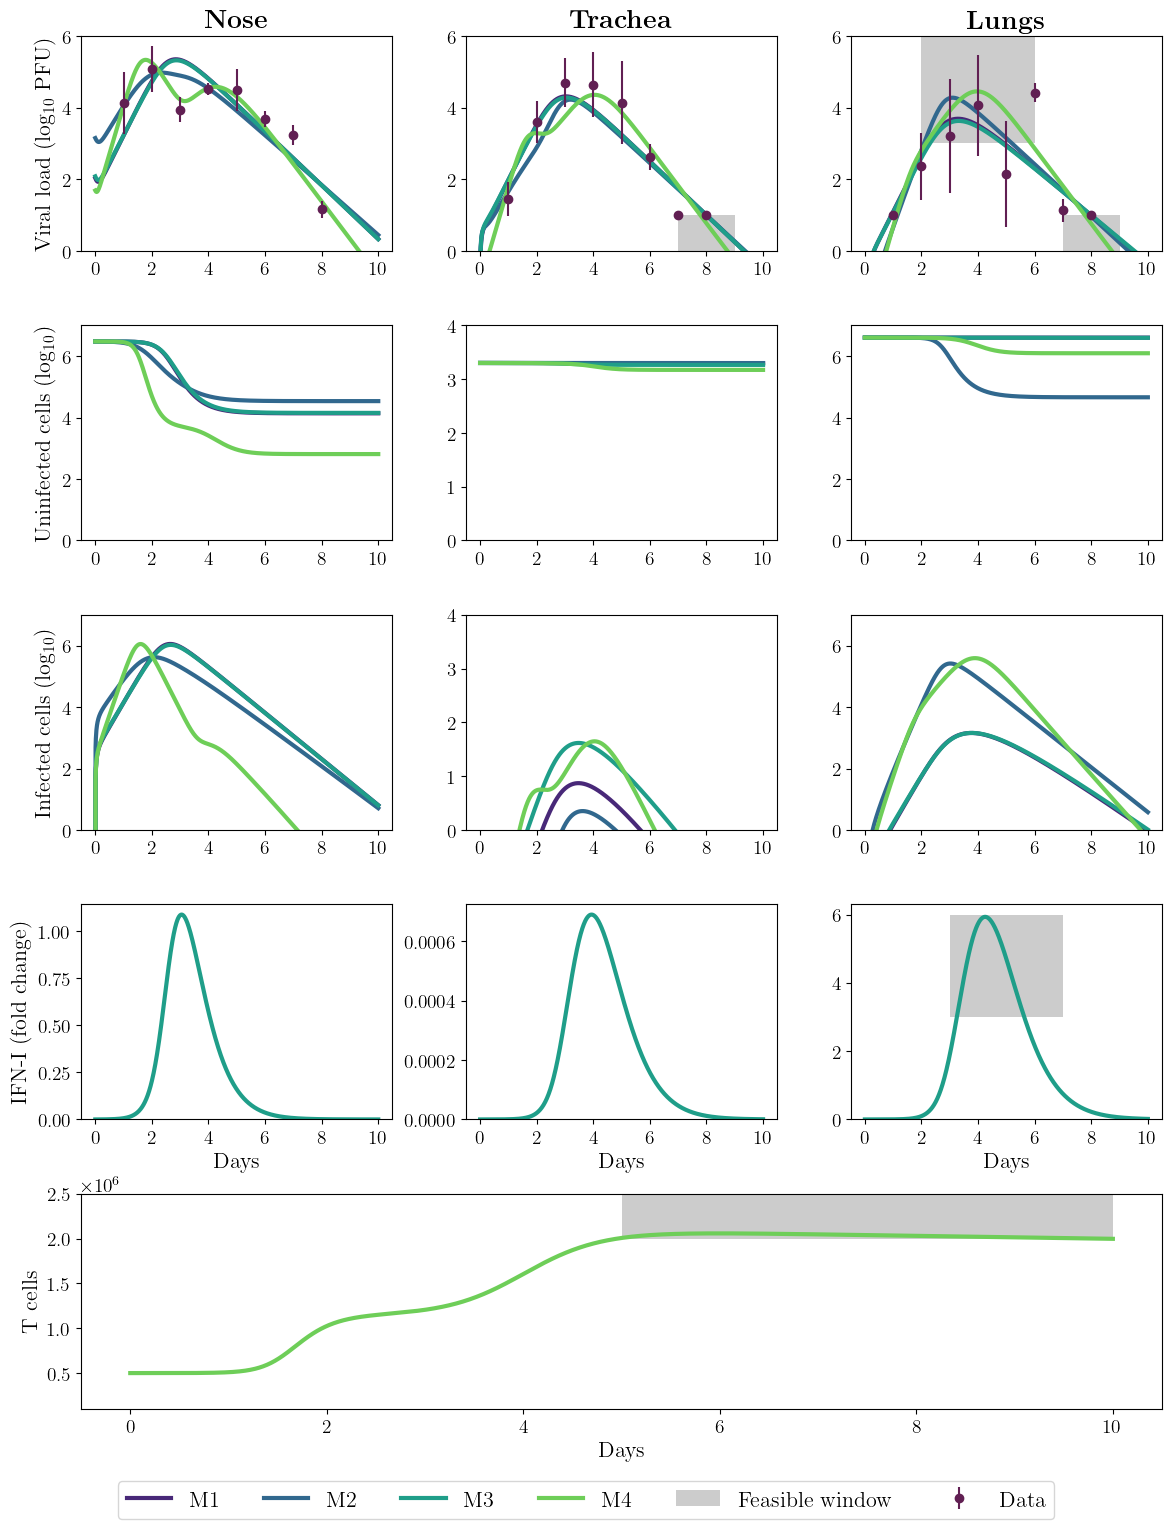

In [120]:
# Plots
fig = plt.figure(figsize=(12, 15))
gs = gridspec.GridSpec(5, 3, height_ratios=[1, 1, 1, 1, 1])

for idx in range(3):
    # Row 1: V kinetics (columns)
    ax = fig.add_subplot(gs[0, idx])
    ax.plot(t, safeLog10(V_M1[:, idx]), color=viridis_pal[0], lw=3, label="M1")
    ax.plot(t, safeLog10(V_M2[:, idx]), color=viridis_pal[2], lw=3, label="M2")
    ax.plot(t, safeLog10(V_M3[:, idx]), color=viridis_pal[4], lw=3, label="M3")
    ax.plot(t, safeLog10(V_M4[:, idx]), color=viridis_pal[6], lw=3, label="M4")
    # ax.scatter(dfData_V['Day'], dfData_V.iloc[:, idx+1], color=rocket_pal[0], s=50, label="Data")
    ax.errorbar(x=dfData_V['Day'], y=dfData_V.iloc[:, idx+1], yerr=dfData_V.iloc[:, idx+4], fmt='o',
                color=rocket_pal[0], label="Data")
    if idx == 0:
        ax.set_ylabel("Viral load (log$_{10}$ PFU)")
        ax.set_title(r"\bf{Nose}")
    if idx == 1:
        ax.set_title(r"\bf{Trachea}")
        tmin, tmax = 7, 9
        vmin, vmax = 0, 1
        rect = plt.Rectangle((tmin, vmin), tmax-tmin, vmax-vmin, fc='gray', alpha = 0.4, zorder=-1)
        ax.add_patch(rect)
    if idx == 2:
        ax.set_title(r"\bf{Lungs}")
        tmin, tmax = 2, 6
        vmin, vmax = 3, 6
        rect = plt.Rectangle((tmin, vmin), tmax-tmin, vmax-vmin, fc='gray', alpha = 0.4, zorder=-1, label="Feasible window")
        ax.add_patch(rect)

        tmin, tmax = 7, 9
        vmin, vmax = 0, 1
        rect = plt.Rectangle((tmin, vmin), tmax-tmin, vmax-vmin, fc='gray', alpha = 0.4, zorder=-1)
        ax.add_patch(rect)

        handles, labels = ax.get_legend_handles_labels()
        
    ax.set_ylim((0, 6))

    # Row 2: U kinetics for i=1,2,3 (columns)
    ax = fig.add_subplot(gs[1, idx])
    ax.plot(t, safeLog10(U_M1[:, idx]), color=viridis_pal[0], lw=3, label="U")
    ax.plot(t, safeLog10(U_M2[:, idx]), color=viridis_pal[2], lw=3)
    ax.plot(t, safeLog10(U_M3[:, idx]), color=viridis_pal[4], lw=3)
    ax.plot(t, safeLog10(U_M4[:, idx]), color=viridis_pal[6], lw=3)
    
    if idx == 0:
        ax.set_ylabel("Uninfected cells (log$_{10}$)")
        ax.set_ylim((0,7))
    if idx == 1:
        ax.set_ylim((0,4))
    if idx == 2:
        ax.set_ylim((0,7))

    # Row 3: I kinetics for i=1,2,3 (columns)
    ax = fig.add_subplot(gs[2, idx])
    ax.plot(t, safeLog10(I_M1[:, idx]), color=viridis_pal[0], lw=3, label="I")
    ax.plot(t, safeLog10(I_M2[:, idx]), color=viridis_pal[2], lw=3)
    ax.plot(t, safeLog10(I_M3[:, idx]), color=viridis_pal[4], lw=3)
    ax.plot(t, safeLog10(I_M4[:, idx]), color=viridis_pal[6], lw=3)
    
    if idx == 0:
        ax.set_ylabel("Infected cells (log$_{10}$)")
        ax.set_ylim((0,7))
    if idx == 1:
        ax.set_ylim((0,4))
    if idx == 2:
        ax.set_ylim((0,7))
    
    # Row 3: F kinetics for i=1,2,3 (columns)
    ax = fig.add_subplot(gs[3, idx])
    ax.plot(t, F_M3[:, idx], color=viridis_pal[4], lw=3, label="IFN")
    if idx == 0:
        ax.set_ylabel("IFN-I (fold change)")
    if idx == 2:
        tmin, tmax = 3, 7
        fmin, fmax = 3, 6
        rect = plt.Rectangle((tmin, fmin), tmax-tmin, fmax-fmin, fc='gray', alpha = 0.4, zorder=-1)
        ax.add_patch(rect)
    ax.set_ylim((0))
    ax.set_xlabel("Days")
    # ax.legend()

# Row 4: one plot spanning all three columns for T cell kinetics
ax = fig.add_subplot(gs[4, :])
ax.plot(t, T_M4, color=viridis_pal[6], lw=3, label="T cell")
tmin, tmax = 5, 10
Tmin, Tmax = 2e6, 5e6
rect = plt.Rectangle((tmin, Tmin), tmax-tmin, Tmax-Tmin, fc='gray', alpha = 0.4, zorder=-1)
ax.add_patch(rect)
ax.set_ylim((1e5, 2.5e6))

ax.set_ylabel("T cells")
ax.set_xlabel("Days")

fig.legend(handles, labels, loc="lower center", ncol=6, frameon=True, bbox_to_anchor=(0.5, -0.03))

for ax in fig.axes:
    ax.xaxis.set_major_locator(MultipleLocator(2))

plt.tight_layout(h_pad=0.2, w_pad=0.5)
# plt.savefig("Models_V8.pdf")

plt.show()

## 6. Bootstraping

In [53]:
def make_boot_df(dfData_V, samples=5, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    
    days   = dfData_V['Day'].to_numpy()
    nose   = dfData_V['nose'].to_numpy()
    trach  = dfData_V['trachea'].to_numpy()
    lung   = dfData_V['lung'].to_numpy()
    stdN   = dfData_V['stdN'].to_numpy()
    stdT   = dfData_V['stdT'].to_numpy()
    stdL   = dfData_V['stdL'].to_numpy()

    n_time = len(dfData_V)

    # Base standard normal draws
    z_nose  = rng.normal(size=(n_time, samples))
    z_trach = rng.normal(size=(n_time, samples))
    z_lung  = rng.normal(size=(n_time, samples))

    # Broadcast means and stds to (n_time, samples)
    nose_samp  = nose[:,  None] + stdN[:,  None] * z_nose
    trach_samp = trach[:, None] + stdT[:, None] * z_trach
    lung_samp  = lung[:, None] + stdL[:, None] * z_lung

    # Repeat days and flatten samples
    days_rep   = np.repeat(days, samples)
    nose_flat  = nose_samp.ravel()
    trach_flat = trach_samp.ravel()
    lung_flat  = lung_samp.ravel()

    dfData = pd.DataFrame({
        'Day':     days_rep,
        'nose':    nose_flat,
        'trachea': trach_flat,
        'lung':    lung_flat,
    })
    return dfData

In [54]:
def model_M1(y, t, params):
    # Unpack state variables
    U1, U2, U3, I1, I2, I3, V1, V2, V3 = y

    # arrays of shape (3,)
    beta = 10**params['beta']
    delta = np.array([1.8, 1.8, 1.8])
    p = np.array([1.0, 1.0, 1.0])
    c = np.array([4.2, 4.2, 4.2])

    # For the Gamma matrix:
    gamma12 = 10**params['gamma12']
    gamma21 = 10**params['gamma21']
    gamma23 = 10**params['gamma23']
    gamma32 = 10**params['gamma32']
    
    # Construct Gamma matrix
    Gamma = np.array([
        [-gamma12,  gamma21,       0],
        [ gamma12, -gamma21-gamma23, gamma32],
        [      0,  gamma23,     -gamma32]
    ])
    
    U = np.array([U1, U2, U3])
    I = np.array([I1, I2, I3])
    V = np.array([V1, V2, V3])
    
    # Compute derivatives
    dU_dt = -beta * U * V
    dI_dt = beta * U * V - delta * I
    dV_dt = p * I - c * V + Gamma.dot(V)
    
    # Concatenate derivatives into a single array
    dydt = np.concatenate([dU_dt, dI_dt, dV_dt])
    return dydt

In [55]:
def LRSS_M1(params, dfData, model, initialCond):

    # Parameter dictionary
    pars = {
        'V1_0': 10**params[0],
        'beta': np.array([params[1], params[2], params[3]]),
        'gamma12': params[4],
        'gamma21': params[5],
        'gamma23': params[6],
        'gamma32': params[7]
    }

    # Initial condition
    y0 = initialCond.copy()
    y0[6] = pars['V1_0']

    # Original times (can contain duplicates)
    t_data = dfData.iloc[:, 0].values

    # Unique times for integration
    t_unique = np.unique(t_data)
    if not (t_unique == 0).any():
        t_unique = np.insert(t_unique, 0, 0.0)

    ####################################
    # This part checks to see if any constraints have been violated.
    tsim = np.linspace(0, np.max(t_unique), 501)
    sol_sim = odeint(model, y0, tsim, args=(pars,))

    penalty = 0.0

    #### Lung viral load
    Vsim = sol_sim[:, 8]
    tmin, tmax = 2, 6
    vmin, vmax = 10**3, 10**6
    mask = (tsim >= tmin) & (tsim <= tmax)
    if not np.any((Vsim[mask] >= vmin) & (Vsim[mask] <= vmax)):
        penalty += 1000

    tmin, tmax = 7, 9
    vmax = 10
    mask = (tsim >= tmin) & (tsim <= tmax)
    if not np.any(Vsim[mask] <= vmax):
        penalty += 1000

    #### Trachea viral load
    Vsim = sol_sim[:, 7]
    tmin, tmax = 7, 9
    vmax = 10
    mask = (tsim >= tmin) & (tsim <= tmax)
    if not np.any(Vsim[mask] <= vmax):
        penalty += 1000
    ####################################

    # Integrate on unique time grid
    sol_unique = odeint(model, y0, t_unique, args=(pars,))
    V_unique = sol_unique[:, 6:9]

    # Map unique-time solution back to original times (including duplicates)
    # For each time in t_data, find its index in t_unique
    idx = np.searchsorted(t_unique, t_data)
    V_pred = V_unique[idx, :] 

    # Compute LRSS
    LRSS = penalty
    for i in range(3):  # 0: nose, 1: trachea, 2: lungs
        V_obs = dfData.iloc[:, i+1].values  # already in log10 scale
        V_sim = V_pred[:, i]
        # mask where simulated V is positive
        mask = (V_sim > 0)
        resids = V_obs[mask] - safeLog10(V_sim[mask])
        LRSS += np.sum(resids**2)

    return LRSS

In [56]:
def obj(x, dfBootData, model_M1, y0):
    return LRSS_M1(x, dfBootData, model_M1, y0)

In [57]:
def bootstraping(dfData, bounds, y0, rep=10, samples=5, random_state=0):
    rng = np.random.default_rng(random_state)
    params = []
    for r in range(rep):
        dfBootData = make_boot_df(dfData, samples, rng)
        result = differential_evolution(
            obj,
            bounds,
            args=(dfBootData, model_M1, y0),
            workers=-1,          
            updating='deferred',
        )
        # result = differential_evolution(lambda x: LRSS_M1(x, dfBootData, model_M1, y0), bounds)
        params.append(result.x)

        if r%50 == 0:
            print(f"{r} replicates estimated")

    return pd.DataFrame(params, columns=['V1_0', 'beta1', 'beta2', 'beta3', 'gamma12', 'gamma21', 'gamma23', 'gamma32'])

In [58]:
# Initial conditions
U1_0, U2_0, U3_0 = 3e6, 2e3, 4e6
initialCond = [U1_0, U2_0, U3_0]+ 6*[0.0]

# Define parameter bounds in the specified order
bounds = [
    (0, 4.5),                      # V1_0
    (-7, -4), (-7, -4), (-7, -4),  # beta
    (-4, 1), (-4, 1),              # gamma12, gamma21
    (-4, 1), (-4, 1),              # gamma23, gamma32
]

In [59]:
%%time
dfParams = bootstraping(dfData_V, bounds, initialCond, rep=1000, samples=5, random_state=2)

0 replicates estimated
50 replicates estimated
100 replicates estimated
150 replicates estimated
200 replicates estimated
250 replicates estimated
300 replicates estimated
350 replicates estimated
400 replicates estimated
450 replicates estimated
500 replicates estimated
550 replicates estimated
600 replicates estimated
650 replicates estimated
700 replicates estimated
750 replicates estimated
800 replicates estimated
850 replicates estimated
900 replicates estimated
950 replicates estimated
CPU times: user 29min 27s, sys: 6min 15s, total: 35min 42s
Wall time: 6h 42min 41s


In [59]:
# dfParams.to_csv("data/bootParam_v3.csv", index=False)
dfParams = pd.read_csv("data/bootParam_v3.csv")

In [60]:
def simulations(dfPars):
    # Initial conditions
    U1_0, U2_0, U3_0 = 3e6, 2e3, 4e6
    initialCond = [U1_0, U2_0, U3_0]+ 6*[0.0]

    U = []
    I = []
    V = []

    simNum = dfPars.shape[0]
    for i in range(simNum):
        pars = {
                'V1_0': 10**dfPars['V1_0'][i],
                'beta': np.array([dfPars['beta1'][i], dfPars['beta2'][i], dfPars['beta3'][i]]),
                'gamma12': dfPars['gamma12'][i],
                'gamma21': dfPars['gamma21'][i],
                'gamma23': dfPars['gamma23'][i],
                'gamma32': dfPars['gamma32'][i],
            }

        y0 = initialCond.copy()
        y0[6] = pars['V1_0']
        t = np.linspace(0, 10, 1000)
    
        # Run your ODE model
        sol = odeint(model_M1, y0, t, args=(pars,))

        U.append(sol[:, 0:3])
        I.append(sol[:, 3:6])
        V.append(sol[:, 6:9])

    return np.array([U, I, V])

In [61]:
def kinetics(X):
    t = np.linspace(0, 10, 1000)
    
    # statistics over simulations (axis=0)
    median = np.median(X, axis=0)           # shape (1000, 3)
    low = np.percentile(X, 2.5, axis=0)     # 2.5th percentile for 95% CI lower bound
    high = np.percentile(X, 97.5, axis=0)   # 97.5th percentile for 95% CI upper bound
    
    # build DataFrame
    df = pd.DataFrame(np.column_stack([
            t,
            median[:, 0], low[:, 0], high[:, 0],   # nose
            median[:, 1], low[:, 1], high[:, 1],   # trachea
            median[:, 2], low[:, 2], high[:, 2],   # lungs
        ]),
        columns=[
            "Day",
            "nose_median", "nose_low", "nose_high",
            "trachea_median", "trachea_low", "trachea_high",
            "lungs_median", "lungs_low", "lungs_high",
        ],
    )

    return df

In [62]:
U, I, V = simulations(dfParams)

In [63]:
dfU = kinetics(U)
dfI = kinetics(I)
dfV = kinetics(V)

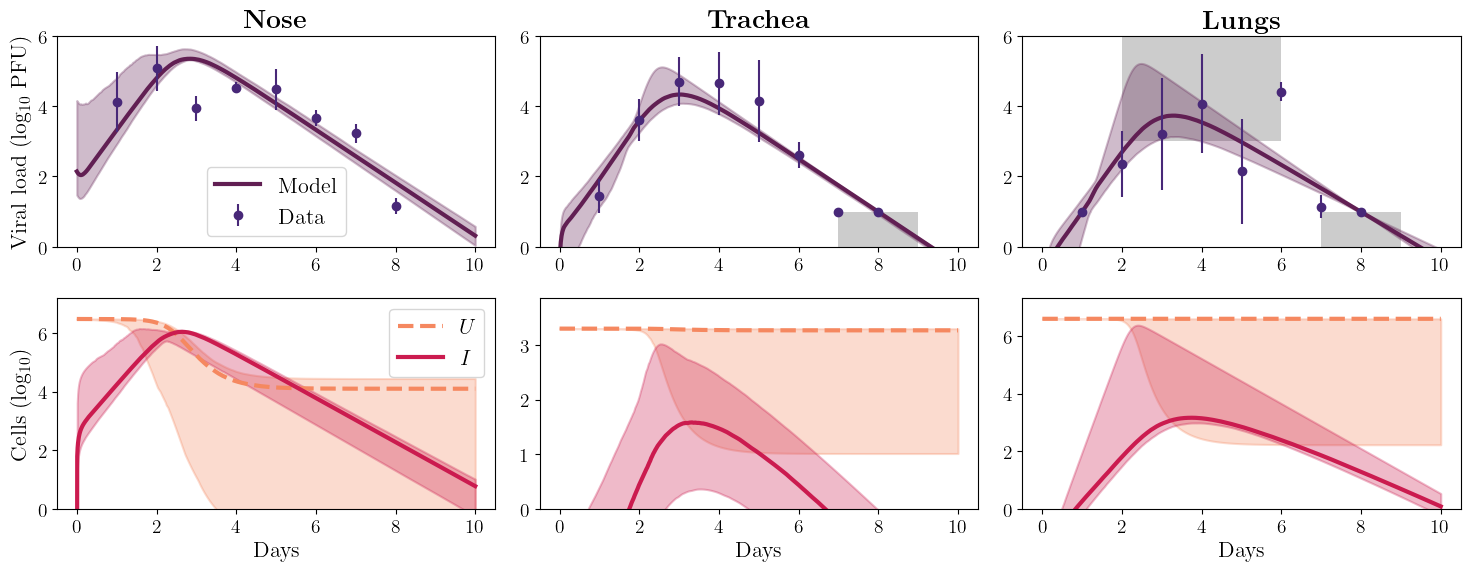

In [66]:
# Plots
fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1])

for i in range(3):
    idx = i*3 + 1
    # Row 1: V kinetics (columns)
    ax = fig.add_subplot(gs[0, i])
    ax.plot(dfV['Day'], safeLog10(dfV.iloc[:, idx]), color=rocket_pal[0], lw=3, label="Model")
    ax.fill_between(dfV['Day'], safeLog10(dfV.iloc[:, idx+1]), safeLog10(dfV.iloc[:, idx+2]),
                    color=rocket_pal[0], alpha=0.3, lw=1.5)
    
    # ax.scatter(dfData_V['Day'], dfData_V.iloc[:, i+1], color=viridis_pal[0], s=50, label="Data")
    ax.errorbar(x=dfData_V['Day'], y=dfData_V.iloc[:, i+1], yerr=dfData_V.iloc[:, i+4], fmt='o',
                color=viridis_pal[0], label="Data")
    if i == 0:
        ax.set_ylabel("Viral load (log$_{10}$ PFU)")
        ax.legend(loc='lower center')
        ax.set_title(r"\bf{Nose}")
    if i == 1:
        ax.set_title(r"\bf{Trachea}")
        tmin, tmax = 7, 9
        vmin, vmax = 0, 1
        rect = plt.Rectangle((tmin, vmin), tmax-tmin, vmax-vmin, fc='gray', alpha = 0.4, zorder=-1)
        ax.add_patch(rect)
    if i == 2:
        ax.set_title(r"\bf{Lungs}")
        tmin, tmax = 2, 6
        vmin, vmax = 3, 6
        rect = plt.Rectangle((tmin, vmin), tmax-tmin, vmax-vmin, fc='gray', alpha = 0.4, zorder=-1, label="Feasible window")
        ax.add_patch(rect)
        tmin, tmax = 7, 9
        vmin, vmax = 0, 1
        rect = plt.Rectangle((tmin, vmin), tmax-tmin, vmax-vmin, fc='gray', alpha = 0.4, zorder=-1)
        ax.add_patch(rect)
    ax.set_ylim((0, 6.0))

    # Row 2: U & I kinetics for i=1,2,3 (columns)
    ax = fig.add_subplot(gs[1, i])
    ax.plot(dfU['Day'], safeLog10(dfU.iloc[:, idx]), color=rocket_pal[2], lw=3, ls='--', label="$U$")
    ax.fill_between(dfU['Day'], safeLog10(dfU.iloc[:, idx+1]), safeLog10(dfU.iloc[:, idx+2]),
                    color=rocket_pal[2], alpha=0.3, lw=1.5)

    ax.plot(dfI['Day'], safeLog10(dfI.iloc[:, idx]), color=rocket_pal[1], lw=3, label="$I$")
    ax.fill_between(dfI['Day'], safeLog10(dfI.iloc[:, idx+1]), safeLog10(dfI.iloc[:, idx+2]),
                    color=rocket_pal[1], alpha=0.3, lw=1.5)
    
    if i == 0:
        ax.set_ylabel("Cells (log$_{10}$)")
        ax.legend(loc='upper right')
    ax.set_xlabel("Days")
    ax.set_ylim((0))
    

plt.tight_layout()
plt.savefig('modelM1_boot_v3.pdf')

plt.show()

In [67]:
dfParams.columns = ['$V_1(0)$', '$\\beta_1$', '$\\beta_2$', '$\\beta_3$',
                    '$\\gamma_{12}$', '$\\gamma_{21}$', '$\\gamma_{23}$', '$\\gamma_{32}$']
dfParams

,$V_1(0)$,$\beta_1$,$\beta_2$,$\beta_3$,$\gamma_{12}$,$\gamma_{21}$,$\gamma_{23}$,$\gamma_{32}$
0,1.969270,-4.803477,-5.945701,-6.550583,-0.319774,-2.037741,-0.249380,-3.299412
1,1.893057,-4.814171,-4.450575,-6.916347,-0.339713,-1.189985,0.154235,-3.178387
2,1.868245,-4.804863,-4.879471,-6.777277,-0.318205,-2.113137,-0.004797,-2.174988
3,2.314538,-4.884572,-4.450046,-6.510985,-0.574728,-1.444545,-0.220272,-2.661360
4,4.485367,-5.094890,-6.270976,-4.214243,-2.756702,0.884929,-2.208265,0.998657
...,...,...,...,...,...,...,...,...
995,2.000967,-4.810319,-5.650998,-6.829311,-0.276572,-1.326085,0.059983,-3.018395
996,2.888848,-4.838179,-5.433259,-4.240106,-1.409884,0.897531,-1.659874,0.987922
997,2.287327,-4.847557,-5.746522,-6.727114,-0.360083,-2.504546,-0.031338,-3.057562
998,2.424149,-4.771495,-4.616886,-4.217102,-0.884800,0.964365,-2.055151,0.998795


In [68]:
dfParams.describe(percentiles=[0.025, 0.5, 0.975])

,$V_1(0)$,$\beta_1$,$\beta_2$,$\beta_3$,$\gamma_{12}$,$\gamma_{21}$,$\gamma_{23}$,$\gamma_{32}$
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.281444,-4.820652,-5.652655,-6.182087,-0.617634,-1.405066,-0.474229,-1.608541
std,0.632305,0.118612,0.774956,1.061967,0.636266,1.517458,0.865361,1.581470
min,0.991355,-6.631409,-6.999460,-6.999230,-3.074811,-3.990856,-3.834907,-3.998725
2.5%,1.471899,-5.051269,-6.872769,-6.995345,-2.312143,-3.822595,-2.675195,-3.786734
50%,2.142942,-4.820704,-5.713910,-6.657217,-0.346553,-1.626731,-0.099250,-2.034640
97.5%,4.159544,-4.582765,-4.144983,-4.193548,-0.106774,0.965825,0.215481,0.999831
max,4.499811,-4.024033,-4.003957,-4.172843,0.241258,0.999466,0.608012,1.000000


In [69]:
dfBootPars = dfParams.melt(var_name='Parameter', value_name='Value')

In [70]:
dfBootPars['Value'] = 10**dfBootPars['Value']

In [71]:
corrPars = dfParams.corr()
corrPars = np.round(corrPars, 1)        # round numerically
corrPars[corrPars == -0.0] = 0.0        # normalize -0.0 to 0.0

<Axes: >

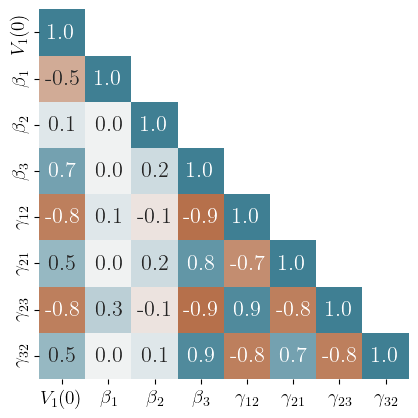

In [72]:
mask = np.triu(np.ones_like(corrPars, dtype=bool), k=1)

cmap =sns.diverging_palette(30, 220, as_cmap=True)
sns.heatmap(corrPars, annot=True, fmt='.1f', cmap=cmap, vmin=-1, vmax=1, mask=mask, cbar=False, square=True)

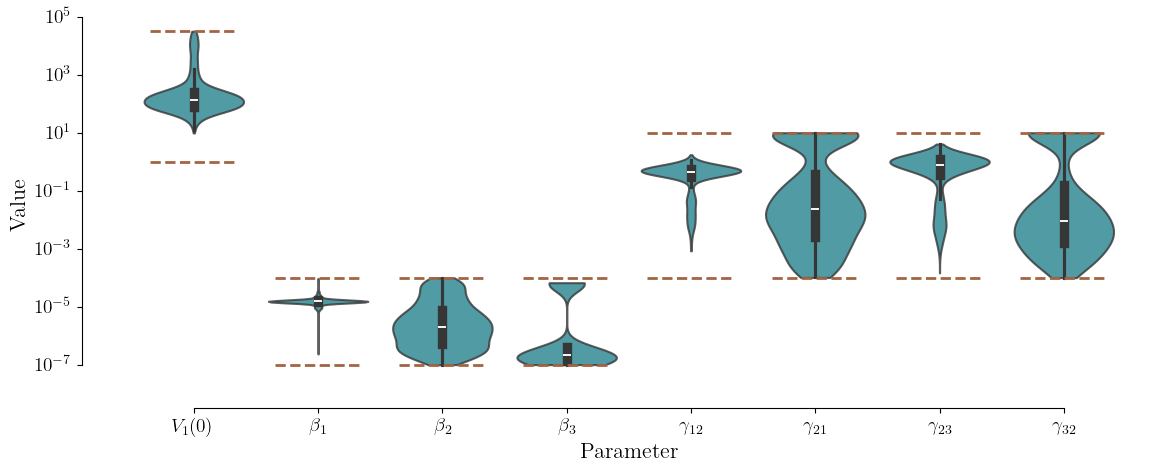

In [103]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5), facecolor="white")

# Violin plot
sns.violinplot(
    data=dfBootPars,
    x="Parameter",
    y="Value",
    log_scale=True,
    cut=0,
    color=viridis_pal[3],
    alpha=0.8,
    linewidth=1.5,
    density_norm="count",
    saturation=1,
    ax=ax
)

# Bounds in log10
bounds = [
    (0, 4.5),                      # V1(0)
    (-7, -4), (-7, -4), (-7, -4),  # beta1–3
    (-4, 1), (-4, 1),              # gamma12, gamma21
    (-4, 1), (-4, 1),              # gamma23, gamma32
]

# Overlay bounds
for i, (bmin, bmax) in enumerate(bounds):
    ymin, ymax = 10**bmin, 10**bmax

    ax.hlines(
        [ymin, ymax],
        i - 0.35, i + 0.35,
        colors="#a36442",
        linestyles="--",
        linewidth=2,
        zorder=3
    )

# Axis formatting
ax.set_yscale("log")
ax.set_ylim(0.99e-8, 1e5)
sns.despine(ax=ax, offset=10, trim=True)

# No legend
ax.legend([], [], frameon=False)

plt.tight_layout()

# plt.savefig("parsM1_boot_v3.pdf")

plt.show()

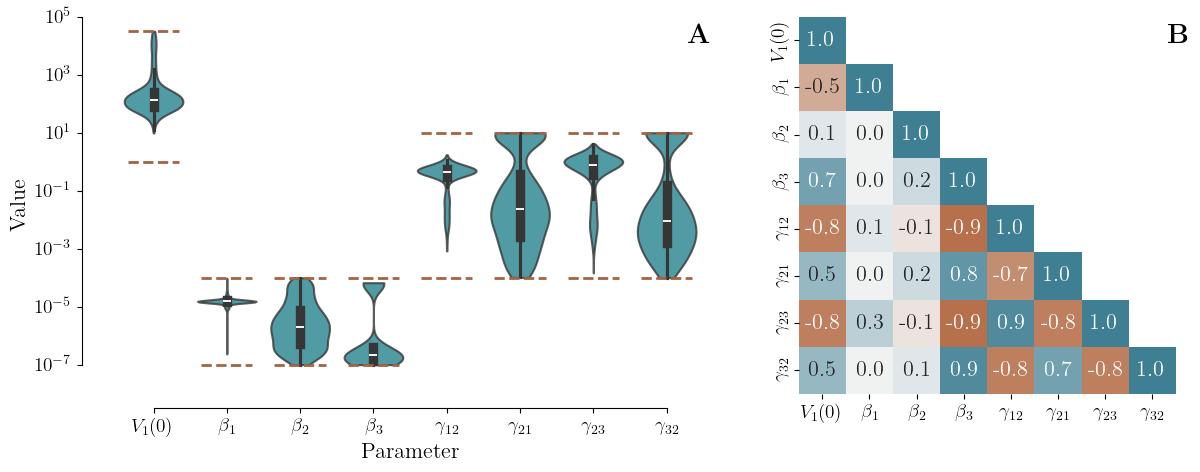

In [117]:
fig, (ax_violin, ax_heat) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(12.5, 5),
    facecolor='white',
    gridspec_kw=dict(width_ratios=[1.5, 1])
)

# --- Left panel: violin plot ---
sns.violinplot(
    data=dfBootPars,
    x='Parameter',
    y='Value',
    log_scale=True,
    cut=0,
    color=viridis_pal[3],
    alpha=0.8,
    linewidth=1.5,
    density_norm="count",
    saturation=1,
    inner_kws=dict(linewidth=2),
    ax=ax_violin
)

# Bounds in log10
bounds = [
    (0, 4.5),                      # V1(0)
    (-7, -4), (-7, -4), (-7, -4),  # beta1–3
    (-4, 1), (-4, 1),              # gamma12, gamma21
    (-4, 1), (-4, 1),              # gamma23, gamma32
]

# Overlay bounds
for i, (bmin, bmax) in enumerate(bounds):
    ymin, ymax = 10**bmin, 10**bmax

    ax_violin.hlines(
        [ymin, ymax],
        i - 0.35, i + 0.35,
        colors="#a36442",
        linestyles="--",
        linewidth=2,
        zorder=3
    )

ax_violin.set_yscale("log")
ax_violin.set_ylim(0.99e-8, 1e5)
sns.despine(ax=ax_violin, offset=10, trim=True)

# Label A in upper-left of left panel
ax_violin.text(
    0.98, 0.98, r"\bf{A}",
    transform=ax_violin.transAxes,
    ha="right", va="top", fontsize=20
)

# --- Right panel: heatmap ---
mask = np.triu(np.ones_like(corrPars, dtype=bool), k=1)
cmap = sns.diverging_palette(30, 220, as_cmap=True)

sns.heatmap(
    corrPars,
    annot=True,
    fmt='.1f',
    cmap=cmap,
    vmin=-1, vmax=1,
    mask=mask,
    cbar=False,
    square=True,
    ax=ax_heat
)

# Label B in upper-left of right panel
ax_heat.text(
    0.98, 0.98, r"\bf{B}",
    transform=ax_heat.transAxes,
    ha="left", va="top", fontsize=20
)

plt.legend([], [], frameon=False)
plt.tight_layout()

# plt.savefig("parsM1_boot_corr_v3.pdf")
# plt.savefig("parsM1_boot_corr_v3.svg")
plt.show()

---
**END OF THE CODE**